## Compressed sensing with QFT

**Compressed sensing objective**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D}$ we want to find a vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } C\mathbf{x} = CF^{-1}\mathbf{s}
$$


**Tensorized extension of compressed sensing**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D\times\cdots\times D}$ represented in TT format with ranks $\{R_i\}_{i=1}^N$ we want to find a TT-vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } \mathcal{C}\mathcal{x} = \mathcal{C}\mathcal{F}^{-1}\mathcal{s}
$$

where $\mathcal{C}\,\&\,\mathcal{F}$ are Matrix Product Operators (MPO).


### Constrained optimization

In [ ]:
# Install packages
!pip install quimb 

In [7]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from scipy.optimize import minimize
from math import sqrt

# =======================================================
# (Example 1) Standard Constrained Optimization in NumPy
# =======================================================

# def f(x):
#     print(x)
#     return sqrt(0.1*x[0]*x[1])

# def ineq_constraint(x):
#     return x[0] - x[1]

# con = {'type': 'ineq', 'fun': ineq_constraint}

# x0 = [1, 1]
# res = minimize(f, x0, method='SLSQP', constraints=con, bounds=[(0, None) for i in range(len(x0))], options={'disp': True, 'iprint': 2})


# ===============================================
# (Example 2) Simple MPS constrained optimization
# ===============================================

# def f(x, H, R, D, verbose=False):
#     # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
#     x = x.reshape(H, R, R, D)

#     # Each MPS core is of shape (Rl, Rr, D)
#     arrays = [x[0][0:1, ...]] + [x[i] for i in range(1, H-1)] + [x[H-1][..., 0:1, :]]
#     if verbose:
#         print('\n'.join(str(a.shape) for a in arrays))

#     # Create the MPS
#     mps = qtn.MatrixProductState(arrays)
#     return mps.norm()


# H, R, D = 8, 2, 2
# con = [{'type': 'ineq', 'fun': lambda x, idx=i: (x[idx] - 0.5)} for i in range(H*R*R*D)]

# x0 = np.random.rand(H*R*R*D)
# res = minimize(f, x0, method='SLSQP', constraints=con, args=(H, R, D), options={'disp': True, 'iprint': 2})


# ================================================
# (Main) MPS compressed sensing (Example 3)
# ================================================

def obj_fn(x, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    x = x.reshape(L, R, R, D)
    x_mps = vec2mps(x, L, R, D)
    return x_mps.norm()  # should make l1 norm

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


L, R, D = 8, 2, 4

# Create MPO transforms
c = np.random.rand(L, R, R, D, D)  # sampler MPO
finv = np.random.rand(L, R, R, D, D)  # inverse fourier MPO
c_mpo = qtn.MatrixProductOperator([c[0][0:1, ...]] + [c[i] for i in range(1, L-1)] + [c[L-1][..., 0:1, :, :]])
finv_mpo = qtn.MatrixProductOperator([finv[0][0:1, ...]] + [finv[i] for i in range(1, L-1)] + [finv[L-1][..., 0:1, :, :]])
w_mpo = c_mpo.apply(finv_mpo)  # combined MPO


# Original signal
x_targ_mps = qtn.MPS_rand_state(L=L, bond_dim=R, phys_dim=D)  # dense tensor
y_mps = c_mpo.apply(x_targ_mps)

con = []
# i.e. y - CFs = 0
con.append({'type': 'eq', 'fun': lambda s_t: (w_mpo.apply(vec2mps(s_t, L, R, D)) - y_mps).norm()})

x0 = np.random.rand(L*R*R*D)
res = minimize(obj_fn, x0, method='SLSQP', constraints=con, args=(L, R, D), options={'disp': True, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1   130     5.750997E+10     2.693384E+02
    2   261     2.657291E+05     2.150438E+02
    3   392     6.523824E+03     2.093686E+02
    4   522     6.971943E+03     1.970488E+02
    5   652     4.275163E+09     1.804037E+02
    6   783     3.435327E+06     1.846679E+02
    7   913     3.178742E+07     2.132773E+02
    8  1045     5.473043E+10     2.121769E+02
    9  1177     5.049110E+13     2.702926E+02
   10  1309     1.991316E+16     3.112463E+02
   11  1442     4.339439E+09     3.637591E+02
   12  1573     7.850922E+10     4.811807E+02
   13  1705     9.212569E+07     4.802707E+02
   14  1836     6.248081E+09     2.660805E+02
   15  1967     4.597640E+11     2.641672E+02
   16  2099     1.227795E+06     2.463116E+02
   17  2230     2.198992E+08     1.738935E+02
   18  2361     2.419083E+10     1.240734E+02
   19  2493     7.663578E+10     1.413877E+02
   20  2625     7.405568E+05     1.144086E+02
   21  2757     1.371338E+07     9

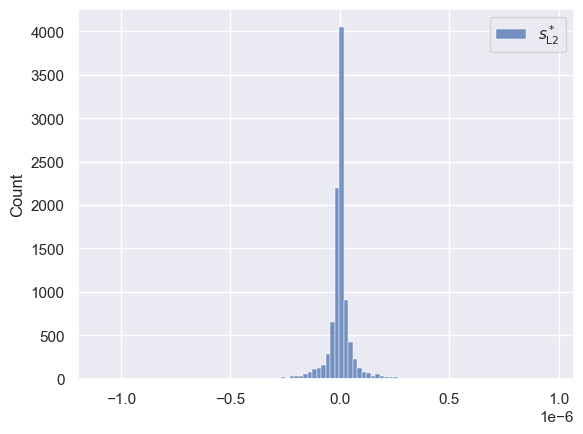

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append(amp)

    return results


samples_l2 = random_samples_with_amplitudes(vec2mps(res.x, L, R, D), num_samples=10000)
samples_random = random_samples_with_amplitudes(vec2mps(x0, L, R, D), num_samples=10000)
sns.set_theme()
sns.histplot(samples_l2, bins=100, label=r"$s^*_{\mathrm{L2}}$")
# sns.histplot(samples_random, bins=100, label=r"$s_0$")
plt.legend()
plt.show()

#### Matrix Compressed Sensing

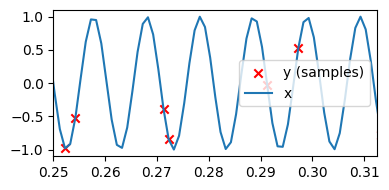

  NIT    FC           OBJFUN            GNORM
    1  1001     5.060863E+02     3.162278E+01
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 506.08629849365354
            Iterations: 1
            Function evaluations: 1001
            Gradient evaluations: 1


In [28]:
# ======================================
# Compressed Sensing (1D)
# ======================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Hyperparameters
filepath = "../../data/einstein/einstein.jpg"
n_points = 1000
n_samples = 100

# Data
t = np.linspace(0, 1, n_points)
x = np.cos(2*97*np.pi*t)

# Sampler matrix
C = np.random.randn(n_samples, x.shape[0])
y = C @ x.reshape(-1)
perm = np.floor(np.random.rand(n_samples) * n_points).astype(int)
C = np.eye(n_points)[perm]
y = C @ x.reshape(-1)

F = np.fft.fft(np.eye(n_points))
Finv = np.conj(F) / n_points


# =================================================================
# Plot the 1D signal
# =================================================================
plt.figure(figsize=(4,2))
plt.scatter(t[perm], y, label='y (samples)', marker='x', color='red')  # samples only
plt.plot(t, x, label='x')
plt.xlim(1024/4096, 1280/4096)
plt.tight_layout()
plt.legend()
plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy
# =================================================================


def obj_fn(s_t):
    return np.linalg.norm(s_t, 1)

con = []
con.append({'type': 'eq', 'fun': lambda s_t: (C @ ( Finv @ s_t)) - y})

s_0 = np.random.rand(x.shape[0])
res = minimize(obj_fn, s_0, method='SLSQP', constraints=con, options={'disp': True, 'iprint': 2})


Iteration limit reached    (Exit mode 9)
            Current function value: 65.01045524256877
            Iterations: 300
            Function evaluations: 78031
            Gradient evaluations: 300
success: False | MSE: 1.258e-09


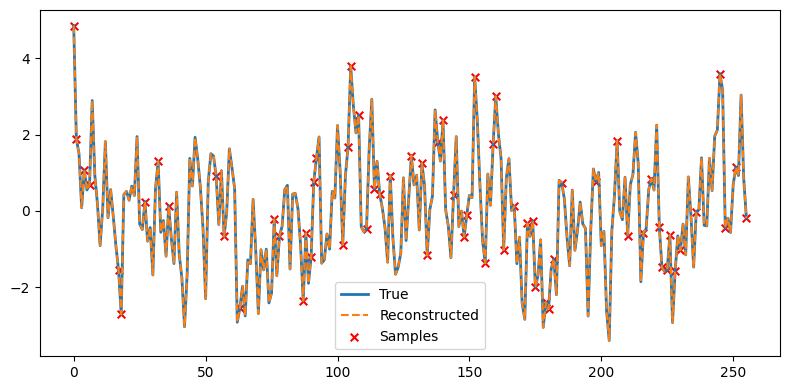

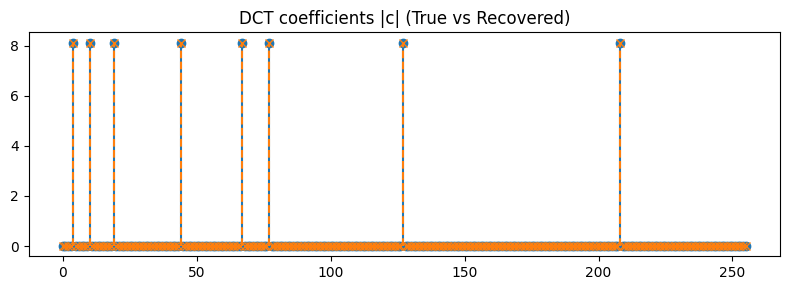

In [35]:
import numpy as np
from scipy.fft import idct
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Problem ---
N, m, k = 256, 64, 8
rng = np.random.default_rng(0)

# Sparse in DCT domain (keeps everything real for SLSQP)
c_true = np.zeros(N)
c_true[rng.choice(N, k, replace=False)] = rng.normal(k)
x_true = idct(c_true, norm='ortho')

perm = rng.choice(N, size=m, replace=False)
y = x_true[perm]

# --- Objective (smoothed L1, no analytic grad) ---
eps = 1e-6
def obj(c):
    # sum sqrt(c^2 + eps)
    # return np.sum(np.sqrt(c*c + eps))
    return np.linalg.norm(c, 1)

# Equality constraint: idct(c)[perm] == y
def cons_fun(c):
    return idct(c, norm='ortho')[perm] - y

con = {'type': 'eq', 'fun': cons_fun}

# --- Solve (finite-difference gradients) ---
c0 = np.zeros(N)
res = minimize(
    obj, c0, method='SLSQP', constraints=[con],
    options={'maxiter': 300, 'ftol': 1e-9, 'disp': True}
)

x_hat = idct(res.x, norm='ortho')
mse = np.mean((x_hat - x_true)**2)
print("success:", res.success, "| MSE:", f"{mse:.3e}")

# --- Plots ---
plt.figure(figsize=(8,4))
plt.plot(x_true, label='True', lw=2)
plt.plot(x_hat, '--', label='Reconstructed', lw=1.5)
plt.scatter(perm, y, c='r', marker='x', s=30, label='Samples')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
(markerline1, stemlines1, _) = plt.stem(np.abs(c_true), linefmt='C0-', markerfmt='C0o', basefmt=' ')
(markerline2, stemlines2, _) = plt.stem(np.abs(res.x), linefmt='C1--', markerfmt='C1x', basefmt=' ')
plt.title('DCT coefficients |c| (True vs Recovered)')
plt.tight_layout(); plt.show()


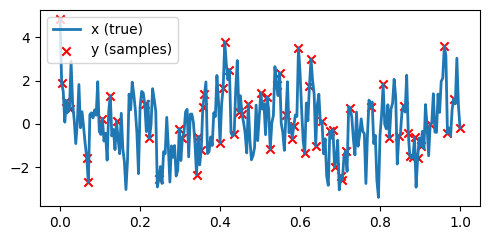

Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.24451001685958
            Iterations: 253
            Function evaluations: 65675
            Gradient evaluations: 253
success: True | MSE: 3.1246119784737084e-07


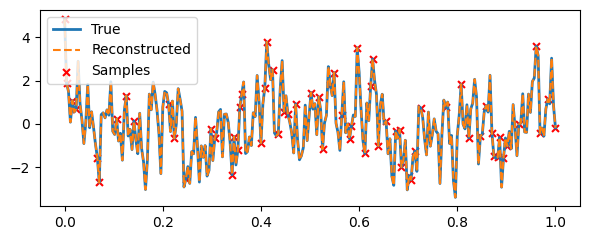

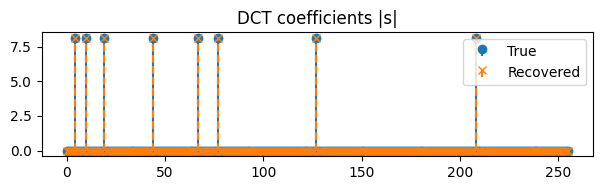

In [36]:
# ======================================
# Compressed Sensing (1D)
# ======================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import idct
from scipy.optimize import minimize

# Hyperparameters
n_points = 256
n_samples = 64
n_nonzeros = 8
rng = np.random.default_rng(0)

# ======================================
# Generate Sparse Signal in DCT Domain
# ======================================
s_true = np.zeros(n_points)
s_true[rng.choice(n_points, n_nonzeros, replace=False)] = rng.normal(n_nonzeros)
x = idct(s_true, norm='ortho')

# Sampler matrix (select random time samples)
perm = rng.choice(n_points, size=n_samples, replace=False)
C = np.eye(n_points)[perm]
y = C @ x

# Sampling times (for plotting)
t = np.linspace(0, 1, n_points)

# =================================================================
# Plot the true and sampled signal
# =================================================================
plt.figure(figsize=(5, 2.5))
plt.plot(t, x, label='x (true)', lw=2)
plt.scatter(t[perm], y, label='y (samples)', color='red', marker='x')
plt.legend()
plt.tight_layout()
plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# =================================================================
eps = 1e-6
def obj_fn(s):
    # Smooth L1 penalty
    return np.sum(np.sqrt(s**2 + eps))

def cons_fun(s):
    # Enforce that sampled points match y
    return (C @ idct(s, norm='ortho')) - y

con = {'type': 'eq', 'fun': cons_fun}

# Initial guess
s0 = np.zeros(n_points)

# Solve
res = minimize(obj_fn, s0, method='SLSQP', constraints=[con],
               options={'disp': True, 'maxiter': 300, 'ftol': 1e-9})

# Reconstruct
x_hat = idct(res.x, norm='ortho')
print("success:", res.success, "| MSE:", np.mean((x_hat - x)**2))

# =================================================================
# Plot reconstruction and DCT spectra
# =================================================================
plt.figure(figsize=(6, 2.5))
plt.plot(t, x, label='True', lw=2)
plt.plot(t, x_hat, '--', label='Reconstructed', lw=1.5)
plt.scatter(t[perm], y, color='red', marker='x', s=25, label='Samples')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6, 2))
plt.stem(np.abs(s_true), linefmt='C0-', markerfmt='C0o', basefmt=' ')
plt.stem(np.abs(res.x), linefmt='C1--', markerfmt='C1x', basefmt=' ')
plt.legend(['True', 'Recovered'])
plt.title('DCT coefficients |s|')
plt.tight_layout(); plt.show()


### Tensor completion

In [1]:
# ===================================
# Tensor completion (Basic Example)
# ===================================

import tntorch as tn
import torch

# Model
t = tn.rand(32, 32, 32, ranks_tt=6, requires_grad=True)

# Data
X = [[0, 0, 0], [0, 0, 1], [0, 0, 2]]
y = torch.randn(3)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)


iter: 0       | loss:   4.453255 | total time:    0.0391
iter: 500     | loss:   0.856309 | total time:    0.2042
iter: 612     | loss:   0.837312 | total time:    0.2405 <- converged (tol=0.0001)


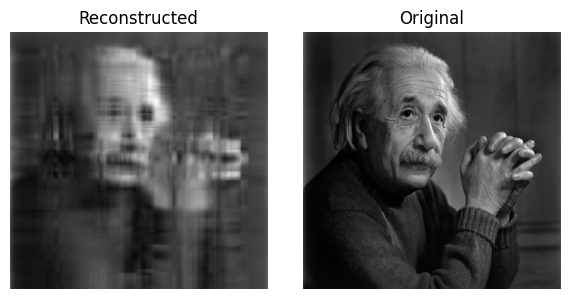

In [ ]:
# ======================================
# Tensor decomposition (Basic Example)
# ======================================

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(filepath, size=(600, 600), show=False):
    img = Image.open(filepath).convert("L")  # converts to grayscale
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized, cmap='gray')
        plt.show()
    return x_down

filepath = "../../data/einstein/einstein.jpg"
height, width = 512, 512
size = (height, width)
n_samples = int(0.1*height*width)
tensor_shape = (8, 8, 8, 8, 8, 8, 8)
rank = 8
image_shape = (height, width)


# Data
x = torch.tensor(load_image(filepath, size))
x = (x - x.mean()) / x.std()
t = tn.Tensor(x, ranks_tt=rank)  # You can also pass a list of ranks

# Plot side-by-side and small
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
x_recons = t.numpy().reshape(*image_shape)
axs[0].imshow(x_recons, vmin=x_recons.min(), vmax=x_recons.max(), cmap='gray')
axs[0].set_title("Reconstructed")
axs[0].axis('off')
axs[1].imshow(x, vmin=x.min(), vmax=x.max(), cmap='gray')
axs[1].set_title("Original")
axs[1].axis('off')
plt.tight_layout()
plt.show()


In [73]:
# Hyperparameters
filepath = "../../data/einstein/einstein.jpg"
height, width = 64, 64
size = (height, width)
n_samples = int(1.0*height*width)
tensor_shape = (8, 8, 8, 8)
rank = 8
image_shape = (height, width)

# Data
x = torch.tensor(load_image(filepath, size, show=False))
x = (x - x.mean()) / x.std()
ids = torch.randperm(height*width)[:n_samples]
ids_tens = torch.unravel_index(ids, tensor_shape)
y = x.reshape(-1).gather(0, ids)  # (n_samples,)
print(f"y: {y.shape} | ids_tens: {ids_tens[0].shape}")

# # =================================================================
# # Sanity check plot samples
# # =================================================================
# obs = np.full((height, width), np.nan, dtype=np.float32)
# r, c = [ids_i.cpu().numpy() for ids_i in torch.unravel_index(ids, (height, width))]
# v = x.reshape(-1)[ids].detach().cpu().numpy()
# v = (v - v.min()) / (v.max() - v.min() + 1e-8)

# obs[r, c] = v
# plt.figure()
# plt.imshow(obs, cmap='gray', vmin=0, vmax=1, origin='upper')  # no axis flip needed
# plt.title("Observed pixels (imshow)")
# plt.axis('off')
# plt.show()
# # =================================================================

# Model
# MPS model
t = tn.rand(*tensor_shape, ranks_tt=rank, requires_grad=True)

# Loss
def loss(t):
    return tn.dist(y, t[ids_tens])

# Optimize
tn.optimize(t, loss)

y: torch.Size([4096]) | ids_tens: torch.Size([4096])
iter: 0       | loss: 1822.342163 | total time:    0.0044
iter: 500     | loss: 105.983009 | total time:    2.0665
iter: 1000    | loss:  62.521255 | total time:    4.3140
iter: 1500    | loss:  55.767944 | total time:    6.4243
iter: 2000    | loss:  50.617241 | total time:    8.5855
iter: 2500    | loss:  44.461815 | total time:   10.6909
iter: 3000    | loss:  39.202785 | total time:   12.7824
iter: 3500    | loss:  34.737370 | total time:   14.8460
iter: 4000    | loss:  30.769203 | total time:   16.9092
iter: 4500    | loss:  27.204878 | total time:   18.9713
iter: 5000    | loss:  23.534599 | total time:   20.9183
iter: 5500    | loss:  20.446127 | total time:   22.8445
iter: 5897    | loss:  19.223276 | total time:   24.4322 <- converged (tol=0.0001)


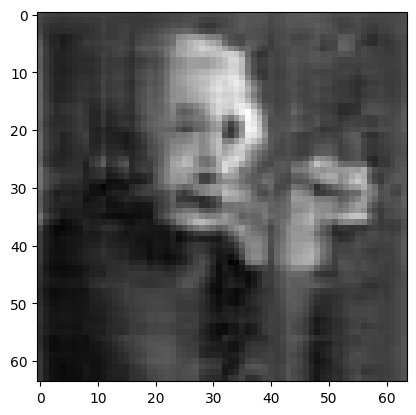

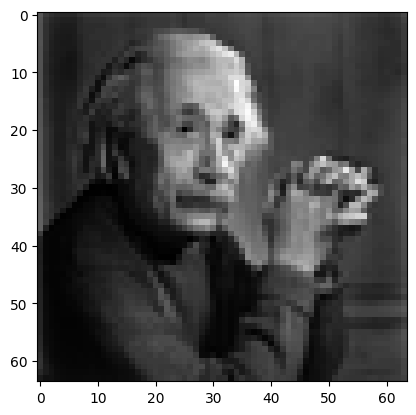

x.min(): -1.42 | x.max(): 4.39 | t.min(): -1.67 | t.max(): 4.09


In [74]:
plt.imshow(t.numpy().reshape(*image_shape), vmin=t.numpy().min(), vmax=t.numpy().max(), cmap='gray')
plt.show()
plt.imshow(x.numpy(), vmin=x.numpy().min(), vmax=x.numpy().max(), cmap='gray')
plt.show()
print(f"x.min(): {x.numpy().min():.2f} | x.max(): {x.numpy().max():.2f} | t.min(): {t.numpy().min():.2f} | t.max(): {t.numpy().max():.2f}")